# Heat Transfer

Heat Transfer Example for JAXSR.

Demonstrates discovering heat transfer correlations from data, including:
- Nusselt number correlations
- Natural convection
- Forced convection

In [1]:
import jax.numpy as jnp
import numpy as np
from jaxsr import BasisLibrary, Constraints, SymbolicRegressor

## Discover Dittus-Boelter correlation for turbulent forced convection.

**True model (Dittus–Boelter):**

$$\mathrm{Nu} = 0.023\,\mathrm{Re}^{0.8}\,\mathrm{Pr}^{0.4}$$

In [2]:
np.random.seed(42)
n_samples = 100

# Reynolds and Prandtl number ranges for turbulent flow
Re = np.random.uniform(10000, 100000, n_samples)
Pr = np.random.uniform(0.7, 100, n_samples)

# Dittus-Boelter correlation
Nu_true = 0.023 * Re**0.8 * Pr**0.4
Nu = Nu_true * (1 + np.random.randn(n_samples) * 0.05)

# Work in log space for power law discovery
log_Re = np.log(Re)
log_Pr = np.log(Pr)
log_Nu = np.log(Nu)

X = jnp.column_stack([log_Re, log_Pr])
y = jnp.array(log_Nu)

print("\nTrue model: Nu = 0.023 * Re^0.8 * Pr^0.4")
print(f"Log form: ln(Nu) = {np.log(0.023):.3f} + 0.8*ln(Re) + 0.4*ln(Pr)")

library = (
    BasisLibrary(n_features=2, feature_names=["ln_Re", "ln_Pr"])
    .add_constant()
    .add_linear()
    .add_interactions(max_order=2)
)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=4,
    strategy="greedy_forward",
)
model.fit(X, y)

print("\nDiscovered expression (log space):")
print(f"  {model.expression_}")
print(f"  R² = {model.metrics_['r2']:.4f}")

# Extract exponents
if "ln_Re" in model.selected_features_:
    idx = model.selected_features_.index("ln_Re")
    re_exp = float(model.coefficients_[idx])
    print(f"\nRe exponent: {re_exp:.2f} (true: 0.80)")

if "ln_Pr" in model.selected_features_:
    idx = model.selected_features_.index("ln_Pr")
    pr_exp = float(model.coefficients_[idx])
    print(f"Pr exponent: {pr_exp:.2f} (true: 0.40)")


True model: Nu = 0.023 * Re^0.8 * Pr^0.4
Log form: ln(Nu) = -3.772 + 0.8*ln(Re) + 0.4*ln(Pr)



Discovered expression (log space):
  y = 0.77*ln_Re + 0.006179*ln_Re*ln_Pr - 3.475 + 0.3415*ln_Pr
  R² = 0.9936

Re exponent: 0.77 (true: 0.80)
Pr exponent: 0.34 (true: 0.40)


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
            ln_Re     0.7700    0.0389    19.77   0.00e+00 [0.6927, 0.8473] ***
      ln_Re*ln_Pr     0.0062    0.0104     0.60   5.53e-01 [-0.0144, 0.0268] 
                1    -3.4748    0.4165    -8.34   5.34e-13 [-4.3016, -2.6479] ***
            ln_Pr     0.3415    0.1109     3.08   2.71e-03 [0.1213, 0.5617] **
  --- *** p<0.001, ** p<0.01, * p<0.05


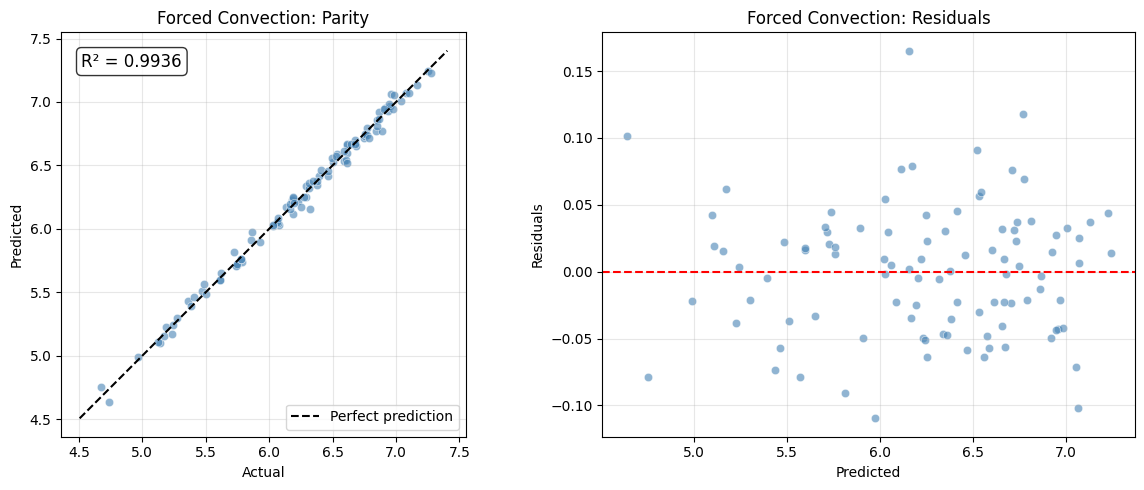


ANOVA Table (Forced Convection)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  ln_Re                         1       21.9745       21.9745     8977.46      0.0000
  ln_Re*ln_Pr                   1       12.8081       12.8081     5232.60      0.0000
  1                             1        1.6278        1.6278      665.00      0.0000
  ln_Pr                         1        0.0232        0.0232        9.48      0.0027
  Model                         3       36.4336       12.1445     4961.51      0.0000
  Residual                     96        0.2350        0.0024                        
  Total                        99       36.6686        0.3704                        
--------------------------------------------------------------------------------

Variance Contributions:
  ln_Re                        60.3%  ***
  ln_Re*ln_Pr                  35.2%  ***
  1     

In [3]:
# Parameter significance, diagnostics, and ANOVA
import matplotlib.pyplot as plt
from scipy import stats as sp_stats

from jaxsr import anova
from jaxsr.plotting import plot_parity

intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

# Parity and residual plots
y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Forced Convection: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Forced Convection: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ANOVA
anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Forced Convection)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Discover natural convection correlation.

**True model (vertical plate, laminar):**

$$\mathrm{Nu} = 0.59\,\mathrm{Ra}^{0.25}$$

In [4]:
np.random.seed(42)
n_samples = 80

# Rayleigh number range for laminar flow
Ra = np.random.uniform(1e4, 1e9, n_samples)

# Churchill-Chu correlation (simplified for laminar)
C = 0.59
n = 0.25
Nu_true = C * Ra**n
Nu = Nu_true * (1 + np.random.randn(n_samples) * 0.03)

# Log transformation
log_Ra = np.log10(Ra)
log_Nu = np.log10(Nu)

X = jnp.array(log_Ra).reshape(-1, 1)
y = jnp.array(log_Nu)

print("\nTrue model: Nu = 0.59 * Ra^0.25")
print(f"Log form: log10(Nu) = {np.log10(C):.3f} + 0.25*log10(Ra)")

library = BasisLibrary(n_features=1, feature_names=["log_Ra"]).add_constant().add_linear()

model = SymbolicRegressor(
    basis_library=library,
    max_terms=2,
    strategy="exhaustive",
)
model.fit(X, y)

print("\nDiscovered expression:")
print(f"  {model.expression_}")
print(f"  R² = {model.metrics_['r2']:.4f}")


True model: Nu = 0.59 * Ra^0.25
Log form: log10(Nu) = -0.229 + 0.25*log10(Ra)



Discovered expression:
  y = - 0.2708 + 0.2549*log_Ra
  R² = 0.9884


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
                1    -0.2708    0.0266   -10.17   6.66e-16 [-0.3238, -0.2178] ***
           log_Ra     0.2549    0.0031    81.56   0.00e+00 [0.2486, 0.2611] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


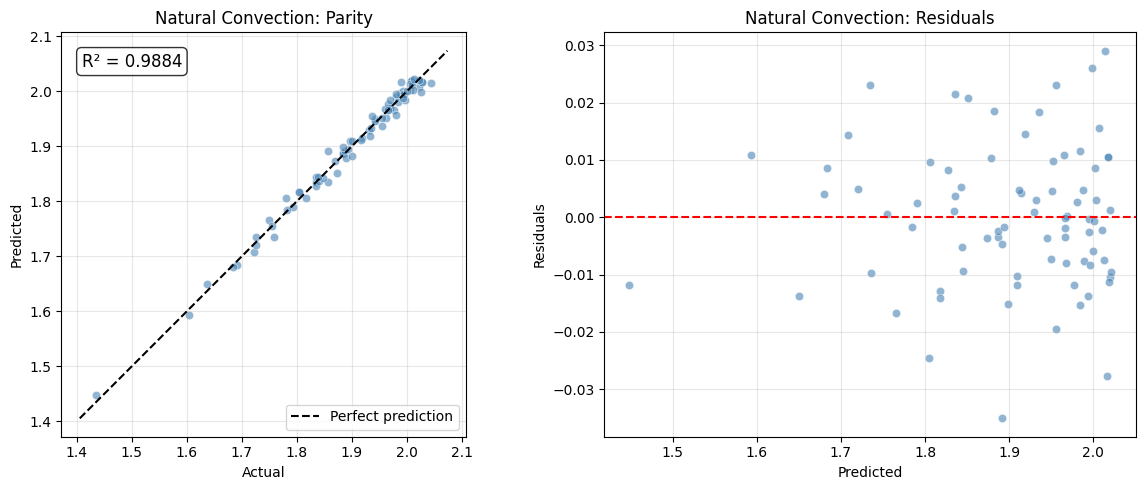


ANOVA Table (Natural Convection)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  1                             1        0.0000        0.0000        0.00      1.0000
  log_Ra                        1        1.0313        1.0313     6652.74      0.0000
  Model                         1        1.0313        1.0313     6652.74      0.0000
  Residual                     78        0.0121        0.0002                        
  Total                        79        1.0434        0.0132                        
--------------------------------------------------------------------------------

Variance Contributions:
  1                             0.0%  
  log_Ra                      100.0%  ***


In [5]:
# Diagnostics and ANOVA for natural convection
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Natural Convection: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Natural Convection: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Natural Convection)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Discover fin efficiency correlation.

**True model:**

$$\eta = \frac{\tanh(mL)}{mL}, \quad mL = \sqrt{\frac{hP}{kA}}\,L$$

In [6]:
np.random.seed(42)
n_samples = 100

# mL parameter (dimensionless fin parameter)
mL = np.random.uniform(0.1, 3.0, n_samples)

# True fin efficiency
eta_true = np.tanh(mL) / mL
eta = eta_true + np.random.randn(n_samples) * 0.01

X = jnp.array(mL).reshape(-1, 1)
y = jnp.array(eta)

print("\nTrue model: eta = tanh(mL) / mL")

# Build library with hyperbolic functions
library = (
    BasisLibrary(n_features=1, feature_names=["mL"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=4)
    .add_transcendental(["tanh", "inv"])
)

# Add the exact form as a custom function
library.add_custom(
    name="tanh(mL)/mL",
    func=lambda X: jnp.tanh(X[:, 0]) / X[:, 0],
    complexity=3,
)

# Constraint: efficiency must be between 0 and 1
constraints = Constraints().add_bounds("y", lower=0.0, upper=1.0)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=3,
    strategy="greedy_forward",
    constraints=constraints,
)
model.fit(X, y)

print("\nDiscovered expression:")
print(f"  {model.expression_}")
print(f"  R² = {model.metrics_['r2']:.4f}")


True model: eta = tanh(mL) / mL



Discovered expression:
  y = 1.001*tanh(mL)/mL
  R² = 0.9984


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
      tanh(mL)/mL     1.0007    0.0013   754.83   0.00e+00 [0.9981, 1.0033] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


/var/folders/sj/cb6cr7_s45d67mqjmsfx8mt80000gn/T/ipykernel_43852/2153483713.py:2: UserWarning: Constraints are active. Classical OLS intervals may not be valid. Consider using bootstrap methods instead.
  intervals = model.coefficient_intervals(alpha=0.05)


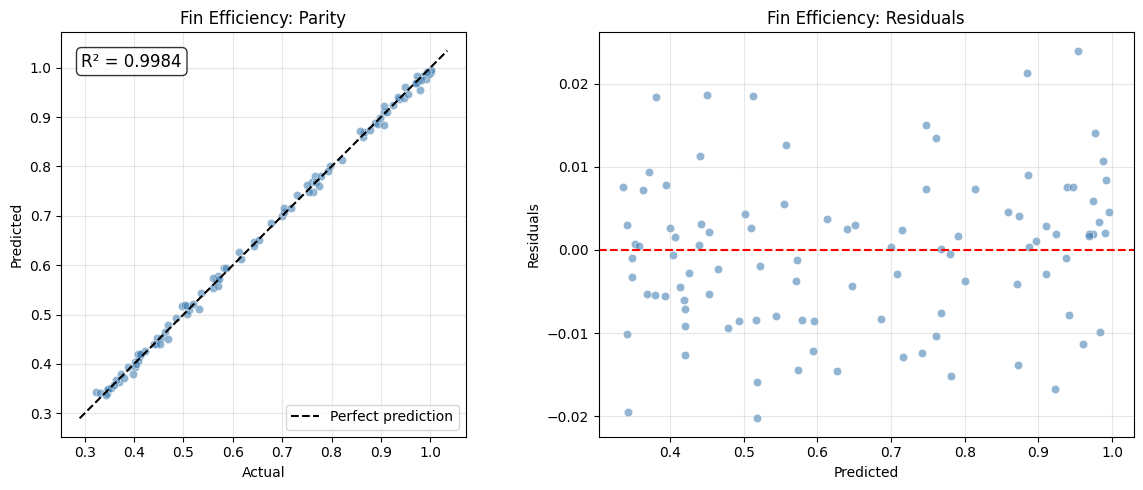


ANOVA Table (Fin Efficiency)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  tanh(mL)/mL                   1        4.9888        4.9888    60029.39      0.0000
  Model                         1        4.9888        4.9888    60029.39      0.0000
  Residual                     99        0.0082        0.0001                        
  Total                        99        4.9970        0.0505                        
--------------------------------------------------------------------------------

Variance Contributions:
  tanh(mL)/mL                 100.0%  ***


In [7]:
# Diagnostics and ANOVA for fin efficiency
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Fin Efficiency: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Fin Efficiency: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Fin Efficiency)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## Discover heat exchanger effectiveness-NTU relationship.

**True model (parallel flow):**

$$\varepsilon = \frac{1 - e^{-\mathrm{NTU}(1+C)}}{1+C}$$

In [8]:
np.random.seed(42)
n_samples = 120

# NTU and capacity ratio
NTU = np.random.uniform(0.1, 5.0, n_samples)
C = np.random.uniform(0.0, 1.0, n_samples)

# Parallel flow effectiveness
eps_true = (1 - np.exp(-NTU * (1 + C))) / (1 + C)
eps = eps_true + np.random.randn(n_samples) * 0.01

X = jnp.column_stack([NTU, C])
y = jnp.array(eps)

print("\nTrue model: eps = (1 - exp(-NTU*(1+C))) / (1+C)")

library = (
    BasisLibrary(n_features=2, feature_names=["NTU", "C"])
    .add_constant()
    .add_linear()
    .add_polynomials(max_degree=2)
    .add_interactions(max_order=2)
    .add_transcendental(["exp"])
)

# Add specific forms
library.add_custom(
    name="exp(-NTU)",
    func=lambda X: jnp.exp(-X[:, 0]),
    complexity=2,
)
library.add_custom(
    name="exp(-NTU*(1+C))",
    func=lambda X: jnp.exp(-X[:, 0] * (1 + X[:, 1])),
    complexity=3,
)
library.add_custom(
    name="1/(1+C)",
    func=lambda X: 1 / (1 + X[:, 1]),
    complexity=2,
)

# Effectiveness between 0 and 1
constraints = Constraints().add_bounds("y", lower=0.0, upper=1.0)

model = SymbolicRegressor(
    basis_library=library,
    max_terms=5,
    strategy="greedy_forward",
    constraints=constraints,
)
model.fit(X, y)

print("\nDiscovered expression:")
print(f"  {model.expression_}")
print(f"  R² = {model.metrics_['r2']:.4f}")


True model: eps = (1 - exp(-NTU*(1+C))) / (1+C)



Discovered expression:
  y = 0.8781*1/(1+C) - 0.6269*exp(-NTU*(1+C)) + 0.1176*C - 0.04741*NTU*C + 0.03022*NTU
  R² = 0.9907


/var/folders/sj/cb6cr7_s45d67mqjmsfx8mt80000gn/T/ipykernel_43852/29207448.py:2: UserWarning: Constraints are active. Classical OLS intervals may not be valid. Consider using bootstrap methods instead.
  intervals = model.coefficient_intervals(alpha=0.05)


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
          1/(1+C)     0.8781    0.0101    86.96   0.00e+00 [0.8581, 0.8981] ***
  exp(-NTU*(1+C))    -0.6269    0.0145   -43.28   0.00e+00 [-0.6556, -0.5982] ***
                C     0.1176    0.0094    12.47   0.00e+00 [0.0989, 0.1363] ***
            NTU*C    -0.0474    0.0043   -10.95   0.00e+00 [-0.0560, -0.0388] ***
              NTU     0.0302    0.0030    10.22   0.00e+00 [0.0244, 0.0361] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


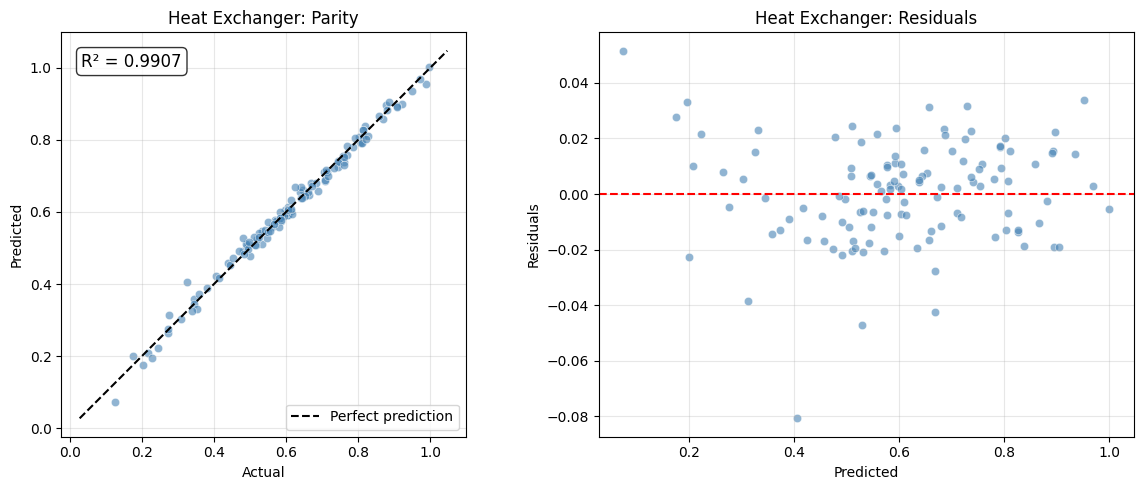


ANOVA Table (Heat Exchanger)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  1/(1+C)                       1        2.2340        2.2340     6475.57      0.0000
  exp(-NTU*(1+C))               1        1.9205        1.9205     5566.93      0.0000
  C                             1        0.0239        0.0239       69.30      0.0000
  NTU*C                         1        0.0087        0.0087       25.33      0.0000
  NTU                           1        0.0381        0.0381      110.41      0.0000
  Model                         4        4.2251        1.0563     3061.75      0.0000
  Residual                    115        0.0397        0.0003                        
  Total                       119        4.2648        0.0358                        
--------------------------------------------------------------------------------

Variance Contributions:
  1/(1+C)

In [9]:
# Diagnostics and ANOVA for heat exchanger
intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Heat Exchanger: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Heat Exchanger: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Heat Exchanger)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")